In [1]:
%load_ext autoreload
%autoreload 2

from deep_bf.data_handler import DataLoader
import torch
import numpy as np

dl = DataLoader("/home/panda/rf_data/")

names = [
    "contrast_speckle_expe_dataset_rf",
    "contrast_speckle_simu_dataset_rf",
    "resolution_distorsion_expe_dataset_rf",
    "resolution_distorsion_simu_dataset_rf",
    "carotid_cross_expe_dataset_rf",
    "carotid_long_expe_dataset_rf"
]

nz = 1024
nx = 512

#nz = 2048
#nx = 256

device = "cuda"
dtype = torch.float32

In [2]:
from deep_bf.wrapper import BenchmarkWrapper

bf_names = [
    "RFGridSampleDAS"
]

output = {}
for name in names:
    print(name)
    pw = dl.get_defined_pwdata(name, "RF")
    angles_idx = np.arange(pw.n_angles)

    f_num = 1.75
    window = "tukey25"

    bw = BenchmarkWrapper(nz, nx, pw, angles_idx, bf_names, f_num, window, device=device, dtype=dtype)
    output[name] = bw.compute_reconstructions()


contrast_speckle_expe_dataset_rf
contrast_speckle_simu_dataset_rf
resolution_distorsion_expe_dataset_rf
resolution_distorsion_simu_dataset_rf
carotid_cross_expe_dataset_rf
carotid_long_expe_dataset_rf


TypeError: mean() received an invalid combination of arguments - got (dtype=NoneType, out=NoneType, axis=int, ), but expected one of:
 * (*, torch.dtype dtype = None)
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


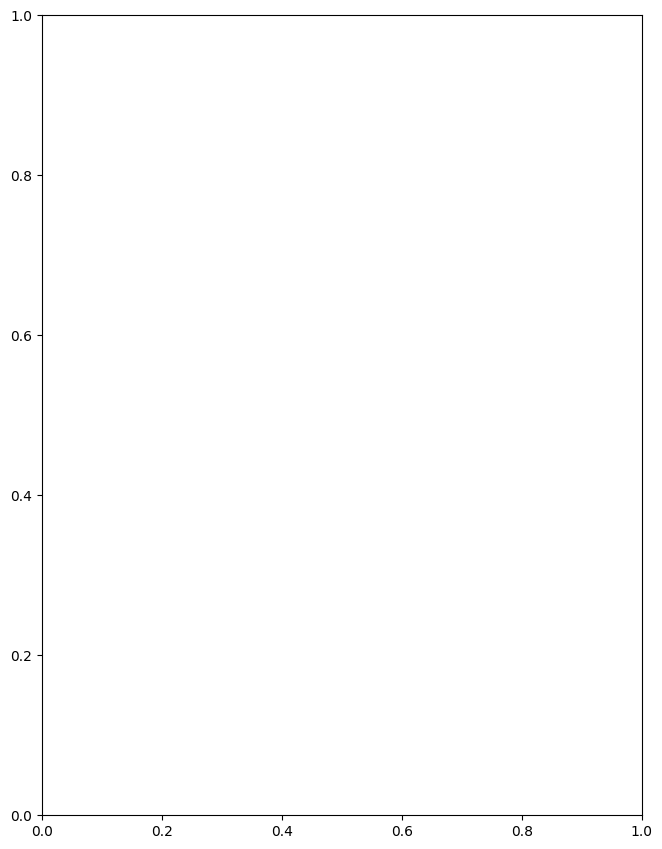

In [3]:
import matplotlib.pyplot as plt
import numpy as np

o = output["contrast_speckle_expe_dataset_rf"][0]

vmin = -60
vmax = 0

fig = plt.figure(figsize=(6, 8), frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

b_mode = o.get_bmode(vmin=vmin, vmax=vmax)
extent = (o.xlims[0], o.xlims[-1], o.zlims[-1], o.zlims[0])


ax.imshow(b_mode, cmap='gray', vmin=-60, vmax=0,
          extent=extent,
          aspect='equal')
ax.set_axis_off()
plt.show()